# Parameters

In [1]:
import datetime

# Time periods
start_date = datetime.datetime(2013, 5, 7)
end_date = datetime.datetime(2018, 8, 31)

print(start_date)
print(end_date)

2013-05-07 00:00:00
2018-08-31 00:00:00


# Imports

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from dateutil import rrule
from datetime import timedelta
from pyramid.arima import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf

# Preparing data

Original data can be found in [datosclima.es](https://datosclima.es/Aemet2013/DescargaDatos.html) *(last accessed date: October 3rd, 2018)*

Download zips from May 2013 to August 2018 and unzip them, one zip in each folder, to replicate the results displayed here.

In [3]:
# Desired list of columns
col_list = ['station_name', 'province', 'temp_max', 'temp_min', 'temp_mean', 'wind_gust', 'wind_max', 'rain_all', 'rain_00_06', 'rain_06_12', 'rain_12_18', 'rain_18_24']
col_list_red = ['rain_all', 'rain_00_06', 'rain_06_12', 'rain_12_18', 'rain_18_24']

# new empty dataframe for results
new = None
j = 0

for i in rrule.rrule(rrule.DAILY, dtstart=start_date, until=end_date - timedelta(days=1)):
    
    # get file path
    file_path = './Aemet{}-{}/Aemet{}-{}-{}.xls'.format(i.year, str(i.month).zfill(2), 
                                               i.year, str(i.month).zfill(2), str(i.day).zfill(2))
       
    try:
        # open Excel
        excel_file = pd.ExcelFile(file_path)
        
        # parse active sheet to pandas
        df = excel_file.parse('Últimos Datos AEMET')
        
        # remove first 4 rows
        aux = df.iloc[4:]

        # new column names
        aux.columns = [col_list]
        
        # aggregate records
        aux = pd.DataFrame(aux[col_list_red].sum(axis=0)).transpose()
        
        # new variables
        aux['rn'] = j
        aux['date'] = datetime.datetime(i.year, i.month, i.day)
        aux['year'] =  i.year
        aux['month'] = i.month
        aux['week_id'] = datetime.datetime(i.year, i.month, i.day).strftime("%U")
    
        # create new df
        new = aux.copy() if new is None else pd.concat((new,aux))
    except:
        print(i, 'No file')
    
    j+= 1

2013-11-21 00:00:00 No file
2014-04-07 00:00:00 No file
2014-04-18 00:00:00 No file
2014-09-07 00:00:00 No file
2016-07-13 00:00:00 No file
2017-02-15 00:00:00 No file


In [4]:
new.columns

MultiIndex(levels=[['province', 'rain_00_06', 'rain_06_12', 'rain_12_18', 'rain_18_24', 'rain_all', 'station_name', 'temp_max', 'temp_mean', 'temp_min', 'wind_gust', 'wind_max', 'rn', 'date', 'year', 'month', 'week_id']],
           labels=[[5, 1, 2, 3, 4, 12, 13, 14, 15, 16]])

In [5]:
new.columns = new.columns.get_level_values(0)
new.columns

Index(['rain_all', 'rain_00_06', 'rain_06_12', 'rain_12_18', 'rain_18_24',
       'rn', 'date', 'year', 'month', 'week_id'],
      dtype='object')

In [ ]:
#save for future use
new.to_csv('./aemet_all.csv', sep = ';', header =  True, index = False)

# Exploring df

In [6]:
new = pd.read_csv('./aemet_all.csv', sep=';')

In [7]:
new.index

RangeIndex(start=0, stop=1936, step=1)

In [8]:
new.head()

,rain_all,rain_00_06,rain_06_12,rain_12_18,rain_18_24,rn,date,year,month,week_id
0,733.7,322.1,190.7,63.7,172.6,0,2013-05-07,2013,5,18
1,402.3,73.1,155.7,123.0,68.5,1,2013-05-08,2013,5,18
2,2075.8,89.9,740.3,813.2,469.1,2,2013-05-09,2013,5,18
3,88.3,46.3,19.8,9.6,13.6,3,2013-05-10,2013,5,18
4,23.8,6.2,3.6,9.8,4.4,4,2013-05-11,2013,5,18


In [9]:
new.tail()

,rain_all,rain_00_06,rain_06_12,rain_12_18,rain_18_24,rn,date,year,month,week_id
1931,13.2,11.3,1.8,0.0,0.1,1937,2018-08-26,2018,8,34
1932,2.6,0.0,0.3,0.8,1.5,1938,2018-08-27,2018,8,34
1933,838.0,70.4,55.5,120.0,599.0,1939,2018-08-28,2018,8,34
1934,714.3,117.6,88.0,199.8,316.1,1940,2018-08-29,2018,8,34
1935,142.7,52.3,7.3,14.0,77.5,1941,2018-08-30,2018,8,34


In [10]:
new.dtypes

rain_all      float64
rain_00_06    float64
rain_06_12    float64
rain_12_18    float64
rain_18_24    float64
rn              int64
date           object
year            int64
month           int64
week_id         int64
dtype: object

In [11]:
new.shape

(1936, 10)

In [12]:
print(start_date)
print(end_date)

2013-05-07 00:00:00
2018-08-31 00:00:00


In [13]:
(end_date - start_date).days

1942

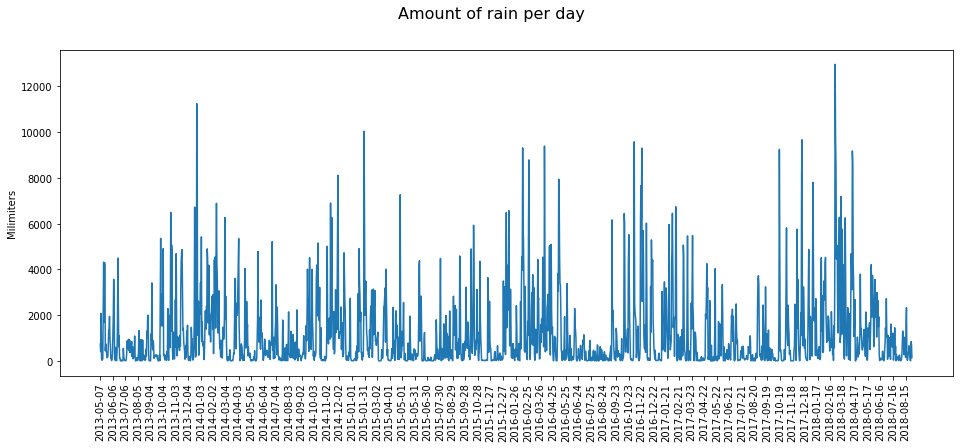

In [14]:
mpl.rc("figure", figsize=(16,6))

fig = plt.figure()
ax = fig.add_subplot(111, adjustable='box-forced')

fig.suptitle('Amount of rain per day', fontsize=16)
plt.ylabel('Milimiters', fontsize=10)

ax.plot(new['date'], new['rain_all'])

ax.set_xticks(ax.get_xticks()[::30])
labels = new['date'][::30]
ax.set_xticklabels(labels)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

# Preparing data for time series

In [15]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv('./aemet_all.csv', sep=';', parse_dates=['date'], index_col='date', date_parser=dateparse)

In [16]:
data.shape

(1936, 9)

In [17]:
data.head()

,rain_all,rain_00_06,rain_06_12,rain_12_18,rain_18_24,rn,year,month,week_id
date,,,,,,,,,
2013-05-07,733.7,322.1,190.7,63.7,172.6,0,2013,5,18
2013-05-08,402.3,73.1,155.7,123.0,68.5,1,2013,5,18
2013-05-09,2075.8,89.9,740.3,813.2,469.1,2,2013,5,18
2013-05-10,88.3,46.3,19.8,9.6,13.6,3,2013,5,18
2013-05-11,23.8,6.2,3.6,9.8,4.4,4,2013,5,18


**Zeros introduces distortion due to logs**

In [18]:
data.loc[data['rain_all'] == 0]

,rain_all,rain_00_06,rain_06_12,rain_12_18,rain_18_24,rn,year,month,week_id
date,,,,,,,,,
2014-03-16,0.0,0.0,0.0,0.2,0.0,313,2014,3,11
2014-03-17,0.0,0.0,0.0,0.0,0.0,314,2014,3,11
2014-05-05,0.0,0.0,0.0,0.1,0.0,363,2014,5,18
2015-03-06,0.0,0.0,0.0,0.0,0.0,668,2015,3,9
2015-03-07,0.0,0.0,0.0,0.0,0.0,669,2015,3,9
2015-08-02,0.0,0.0,0.0,0.0,0.0,817,2015,8,31
2016-08-08,0.0,0.0,0.0,0.0,0.0,1189,2016,8,32
2017-04-08,0.0,0.0,0.0,0.0,0.0,1432,2017,4,14
2017-04-12,0.0,0.0,0.0,0.0,0.0,1436,2017,4,15


In [19]:
data.loc['2014-03-16'] = data.loc['2014-03-15'] + (data.loc['2014-03-18'] - data.loc['2014-03-15'])/3
data.loc['2014-03-17'] = data.loc['2014-03-15'] + (data.loc['2014-03-18'] - data.loc['2014-03-15']) * 2/3
data.loc['2014-03-15':'2014-03-18']

,rain_all,rain_00_06,rain_06_12,rain_12_18,rain_18_24,rn,year,month,week_id
date,,,,,,,,,
2014-03-15,0.300000,0.0,0.100000,0.200000,0.000000,312.0,2014.0,3.0,10.000000
2014-03-16,9.466667,0.0,1.233333,5.666667,3.366667,313.0,2014.0,3.0,10.333333
2014-03-17,18.633333,0.0,2.366667,11.133333,6.733333,314.0,2014.0,3.0,10.666667
2014-03-18,27.800000,0.0,3.500000,16.600000,10.100000,315.0,2014.0,3.0,11.000000


In [20]:
data.loc['2014-05-05'] = data.loc['2014-05-04'] + (data.loc['2014-05-06'] -  data.loc['2014-05-04'])/2
data.loc['2014-05-04':'2014-05-06']

,rain_all,rain_00_06,rain_06_12,rain_12_18,rain_18_24,rn,year,month,week_id
date,,,,,,,,,
2014-05-04,1.60,0.1,1.3,0.20,0.00,362.0,2014.0,5.0,18.0
2014-05-05,23.75,0.4,14.5,7.55,1.95,363.0,2014.0,5.0,18.0
2014-05-06,45.90,0.7,27.7,14.90,3.90,364.0,2014.0,5.0,18.0


In [21]:
data.loc['2015-03-06'] = data.loc['2015-03-05'] - (data.loc['2015-03-05'] - data.loc['2015-03-08']) * 1/3
data.loc['2015-03-07'] = data.loc['2015-03-05'] - (data.loc['2015-03-05'] - data.loc['2015-03-08']) * 2/3
data.loc['2015-03-05':'2015-03-08']

,rain_all,rain_00_06,rain_06_12,rain_12_18,rain_18_24,rn,year,month,week_id
date,,,,,,,,,
2015-03-05,51.700000,35.200000,9.5,6.900000,0.3,667.0,2015.0,3.0,9.000000
2015-03-06,34.666667,23.533333,6.4,4.666667,0.2,668.0,2015.0,3.0,9.333333
2015-03-07,17.633333,11.866667,3.3,2.433333,0.1,669.0,2015.0,3.0,9.666667
2015-03-08,0.600000,0.200000,0.2,0.200000,0.0,670.0,2015.0,3.0,10.000000


In [22]:
data.loc['2015-08-02'] = data.loc['2015-08-01'] + (data.loc['2015-08-03'] -  data.loc['2015-08-01'])/2
data.loc['2015-08-01':'2015-08-03']

,rain_all,rain_00_06,rain_06_12,rain_12_18,rain_18_24,rn,year,month,week_id
date,,,,,,,,,
2015-08-01,737.40,622.50,148.70,20.7,1.0,816.0,2015.0,8.0,30.0
2015-08-02,638.55,311.55,76.75,92.4,190.2,817.0,2015.0,8.0,30.5
2015-08-03,539.70,0.60,4.80,164.1,379.4,818.0,2015.0,8.0,31.0


In [23]:
data.loc['2016-08-08'] = data.loc['2016-08-07'] + (data.loc['2016-08-09'] -  data.loc['2016-08-07'])/2
data.loc['2016-08-07':'2016-08-09']

,rain_all,rain_00_06,rain_06_12,rain_12_18,rain_18_24,rn,year,month,week_id
date,,,,,,,,,
2016-08-07,0.2,0.00,0.2,0.00,0.0,1188.0,2016.0,8.0,32.0
2016-08-08,347.3,28.35,47.0,122.65,149.3,1189.0,2016.0,8.0,32.0
2016-08-09,694.4,56.70,93.8,245.30,298.6,1190.0,2016.0,8.0,32.0


In [24]:
data.loc['2017-04-08'] = data.loc['2017-04-07'] + (data.loc['2017-04-09'] -  data.loc['2017-04-07'])/2
data.loc['2017-04-07':'2017-04-09']

,rain_all,rain_00_06,rain_06_12,rain_12_18,rain_18_24,rn,year,month,week_id
date,,,,,,,,,
2017-04-07,0.1,0.10,0.00,0.00,0.00,1431.0,2017.0,4.0,14.0
2017-04-08,12.7,0.05,0.25,5.35,7.05,1432.0,2017.0,4.0,14.5
2017-04-09,25.3,0.00,0.50,10.70,14.10,1433.0,2017.0,4.0,15.0


In [25]:
data.loc['2017-04-12'] = data.loc['2017-04-11'] + (data.loc['2017-04-13'] -  data.loc['2017-04-11'])/2
data.loc['2017-04-11':'2017-04-13']

,rain_all,rain_00_06,rain_06_12,rain_12_18,rain_18_24,rn,year,month,week_id
date,,,,,,,,,
2017-04-11,1.30,1.1,0.40,0.0,0.0,1435.0,2017.0,4.0,15.0
2017-04-12,2.25,0.6,0.25,0.4,1.1,1436.0,2017.0,4.0,15.0
2017-04-13,3.20,0.1,0.10,0.8,2.2,1437.0,2017.0,4.0,15.0


**Fixing index**

In [26]:
data.dtypes

rain_all      float64
rain_00_06    float64
rain_06_12    float64
rain_12_18    float64
rain_18_24    float64
rn            float64
year          float64
month         float64
week_id       float64
dtype: object

In [27]:
data.index

DatetimeIndex(['2013-05-07', '2013-05-08', '2013-05-09', '2013-05-10',
               '2013-05-11', '2013-05-12', '2013-05-13', '2013-05-14',
               '2013-05-15', '2013-05-16',
               ...
               '2018-08-21', '2018-08-22', '2018-08-23', '2018-08-24',
               '2018-08-25', '2018-08-26', '2018-08-27', '2018-08-28',
               '2018-08-29', '2018-08-30'],
              dtype='datetime64[ns]', name='date', length=1936, freq=None)

In [28]:
# change frequency
data = data.asfreq('d')
data.index

DatetimeIndex(['2013-05-07', '2013-05-08', '2013-05-09', '2013-05-10',
               '2013-05-11', '2013-05-12', '2013-05-13', '2013-05-14',
               '2013-05-15', '2013-05-16',
               ...
               '2018-08-21', '2018-08-22', '2018-08-23', '2018-08-24',
               '2018-08-25', '2018-08-26', '2018-08-27', '2018-08-28',
               '2018-08-29', '2018-08-30'],
              dtype='datetime64[ns]', name='date', length=1942, freq='D')

**Missing values are not supported in some functions**

In [29]:
data.loc[data['rain_all'].isnull()]

,rain_all,rain_00_06,rain_06_12,rain_12_18,rain_18_24,rn,year,month,week_id
date,,,,,,,,,
2013-11-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-04-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-04-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
data.loc['2013-11-21'] = data.loc['2013-11-20'] + (data.loc['2013-11-22'] -  data.loc['2013-11-20'])/2
data.loc['2013-11-20':'2013-11-22']

,rain_all,rain_00_06,rain_06_12,rain_12_18,rain_18_24,rn,year,month,week_id
date,,,,,,,,,
2013-11-20,1334.4,416.8,561.50,241.2,149.20,197.0,2013.0,11.0,46.0
2013-11-21,1374.8,459.0,493.65,244.9,212.95,198.0,2013.0,11.0,46.0
2013-11-22,1415.2,501.2,425.80,248.6,276.70,199.0,2013.0,11.0,46.0


In [31]:
data.loc['2014-04-07'] = data.loc['2014-04-06'] + (data.loc['2014-04-08'] -  data.loc['2014-04-06'])/2
data.loc['2014-04-06':'2014-04-08']

,rain_all,rain_00_06,rain_06_12,rain_12_18,rain_18_24,rn,year,month,week_id
date,,,,,,,,,
2014-04-06,8.8,1.90,6.50,1.80,0.2,334.0,2014.0,4.0,14.0
2014-04-07,58.4,36.45,16.35,7.85,0.5,335.0,2014.0,4.0,14.0
2014-04-08,108.0,71.00,26.20,13.90,0.8,336.0,2014.0,4.0,14.0


In [32]:
data.loc['2014-04-18'] = data.loc['2014-04-17'] + (data.loc['2014-04-19'] -  data.loc['2014-04-17'])/2
data.loc['2014-04-17':'2014-04-19']

,rain_all,rain_00_06,rain_06_12,rain_12_18,rain_18_24,rn,year,month,week_id
date,,,,,,,,,
2014-04-17,20.8,2.60,1.2,16.40,4.4,345.0,2014.0,4.0,15.0
2014-04-18,477.2,2.45,4.1,38.25,448.5,346.0,2014.0,4.0,15.0
2014-04-19,933.6,2.30,7.0,60.10,892.6,347.0,2014.0,4.0,15.0


In [33]:
data.loc['2014-09-07'] = data.loc['2014-09-06'] + (data.loc['2014-09-08'] -  data.loc['2014-09-06'])/2
data.loc['2014-09-06':'2014-09-08']

,rain_all,rain_00_06,rain_06_12,rain_12_18,rain_18_24,rn,year,month,week_id
date,,,,,,,,,
2014-09-06,293.90,1.5,55.00,63.8,174.50,487.0,2014.0,9.0,35.0
2014-09-07,697.15,225.3,59.85,200.4,247.65,488.0,2014.0,9.0,35.5
2014-09-08,1100.40,449.1,64.70,337.0,320.80,489.0,2014.0,9.0,36.0


In [34]:
data.loc['2016-07-13'] = data.loc['2016-07-12'] + (data.loc['2016-07-14'] -  data.loc['2016-07-12'])/2
data.loc['2016-07-12':'2016-07-14']

,rain_all,rain_00_06,rain_06_12,rain_12_18,rain_18_24,rn,year,month,week_id
date,,,,,,,,,
2016-07-12,157.00,54.30,51.8,43.00,10.10,1162.0,2016.0,7.0,28.0
2016-07-13,93.95,34.45,31.5,22.55,6.55,1163.0,2016.0,7.0,28.0
2016-07-14,30.90,14.60,11.2,2.10,3.00,1164.0,2016.0,7.0,28.0


In [35]:
data.loc['2017-02-15'] = data.loc['2017-02-14'] + (data.loc['2017-02-16'] -  data.loc['2017-02-14'])/2
data.loc['2017-02-14':'2017-02-16']

,rain_all,rain_00_06,rain_06_12,rain_12_18,rain_18_24,rn,year,month,week_id
date,,,,,,,,,
2017-02-14,1554.8,721.40,365.00,269.9,233.60,1379.0,2017.0,2.0,7.0
2017-02-15,787.4,366.05,186.25,136.4,116.85,1380.0,2017.0,2.0,7.0
2017-02-16,20.0,10.70,7.50,2.9,0.10,1381.0,2017.0,2.0,7.0


# Decomposing time series

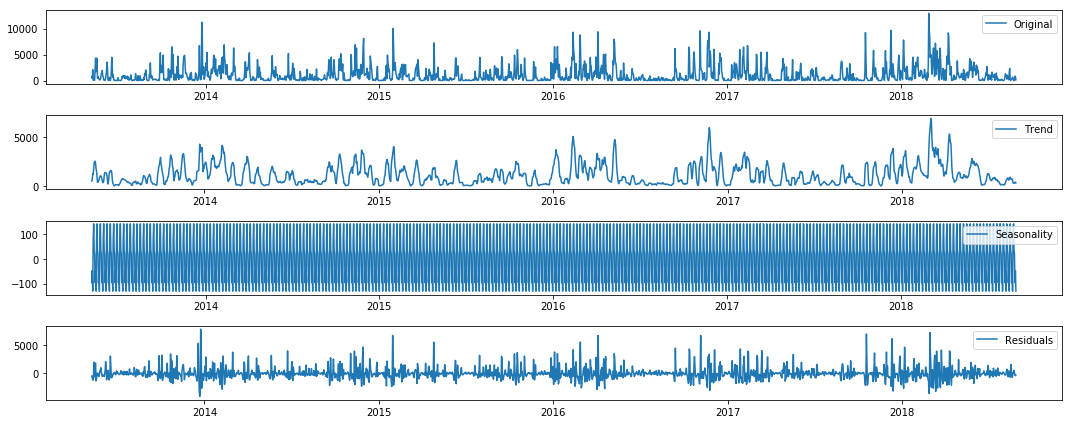

In [36]:
decomposition = seasonal_decompose(data['rain_all'])

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

mpl.rc("figure", figsize=(15,6))
plt.subplot(411)
plt.plot(data['rain_all'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# Preparing month-year ts

In [39]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv('./aemet_all.csv', sep = ';', parse_dates=['date'], index_col='date',date_parser=dateparse)

In [40]:
data.head()

,rain_all,rain_00_06,rain_06_12,rain_12_18,rain_18_24,rn,year,month,week_id
date,,,,,,,,,
2013-05-07,733.7,322.1,190.7,63.7,172.6,0,2013,5,18
2013-05-08,402.3,73.1,155.7,123.0,68.5,1,2013,5,18
2013-05-09,2075.8,89.9,740.3,813.2,469.1,2,2013,5,18
2013-05-10,88.3,46.3,19.8,9.6,13.6,3,2013,5,18
2013-05-11,23.8,6.2,3.6,9.8,4.4,4,2013,5,18


In [41]:
agg_data = data.groupby(['year', 'month']).sum().reset_index()
agg_data = agg_data.drop(columns=['rn', 'week_id'])

In [42]:
agg_data.head(1)

,year,month,rain_all,rain_00_06,rain_06_12,rain_12_18,rain_18_24
0,2013,5,29634.3,6141.5,6955.3,9319.2,8591.2


In [43]:
agg_data = agg_data.assign(new_date=pd.to_datetime(agg_data[['year', 'month']].assign(day=1)))
agg_data = agg_data.drop(columns=['year', 'month'])
agg_data.head()

,rain_all,rain_00_06,rain_06_12,rain_12_18,rain_18_24,new_date
0,29634.3,6141.5,6955.3,9319.2,8591.2,2013-05-01
1,21886.2,5392.1,5400.1,5654.4,6314.1,2013-06-01
2,12508.8,1863.3,801.9,3006.0,7135.5,2013-07-01
3,13331.8,2288.7,2483.6,3927.3,5233.9,2013-08-01
4,23053.8,4188.3,4840.3,6940.1,8206.9,2013-09-01


In [ ]:
agg_data.to_csv('./aemet_year_month.csv', sep=';', header=True, index=False)

# Analysis of month-year ts

**Data preparation**

In [44]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv('./aemet_year_month.csv', sep=';', parse_dates=['new_date'], index_col='new_date',date_parser=dateparse)

In [45]:
data.head()

,rain_all,rain_00_06,rain_06_12,rain_12_18,rain_18_24
new_date,,,,,
2013-05-01,29634.3,6141.5,6955.3,9319.2,8591.2
2013-06-01,21886.2,5392.1,5400.1,5654.4,6314.1
2013-07-01,12508.8,1863.3,801.9,3006.0,7135.5
2013-08-01,13331.8,2288.7,2483.6,3927.3,5233.9
2013-09-01,23053.8,4188.3,4840.3,6940.1,8206.9


In [46]:
data.index

DatetimeIndex(['2013-05-01', '2013-06-01', '2013-07-01', '2013-08-01',
               '2013-09-01', '2013-10-01', '2013-11-01', '2013-12-01',
               '2014-01-01', '2014-02-01', '2014-03-01', '2014-04-01',
               '2014-05-01', '2014-06-01', '2014-07-01', '2014-08-01',
               '2014-09-01', '2014-10-01', '2014-11-01', '2014-12-01',
               '2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01',
               '2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01',
               '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01',
               '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01',
               '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
               '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01',
      

In [47]:
# change frequency to first day of the month
data = data.asfreq('MS')
data.index

DatetimeIndex(['2013-05-01', '2013-06-01', '2013-07-01', '2013-08-01',
               '2013-09-01', '2013-10-01', '2013-11-01', '2013-12-01',
               '2014-01-01', '2014-02-01', '2014-03-01', '2014-04-01',
               '2014-05-01', '2014-06-01', '2014-07-01', '2014-08-01',
               '2014-09-01', '2014-10-01', '2014-11-01', '2014-12-01',
               '2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01',
               '2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01',
               '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01',
               '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01',
               '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
               '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01',
      

In [48]:
data.head()

,rain_all,rain_00_06,rain_06_12,rain_12_18,rain_18_24
new_date,,,,,
2013-05-01,29634.3,6141.5,6955.3,9319.2,8591.2
2013-06-01,21886.2,5392.1,5400.1,5654.4,6314.1
2013-07-01,12508.8,1863.3,801.9,3006.0,7135.5
2013-08-01,13331.8,2288.7,2483.6,3927.3,5233.9
2013-09-01,23053.8,4188.3,4840.3,6940.1,8206.9


In [49]:
# Create a ts to simplify
# Filtering data until December 2017 to predict 2018
ts = data.loc['2013-05-01':'2017-12-01','rain_all']

**Decomposition**

In [50]:
decomposition = seasonal_decompose(ts)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

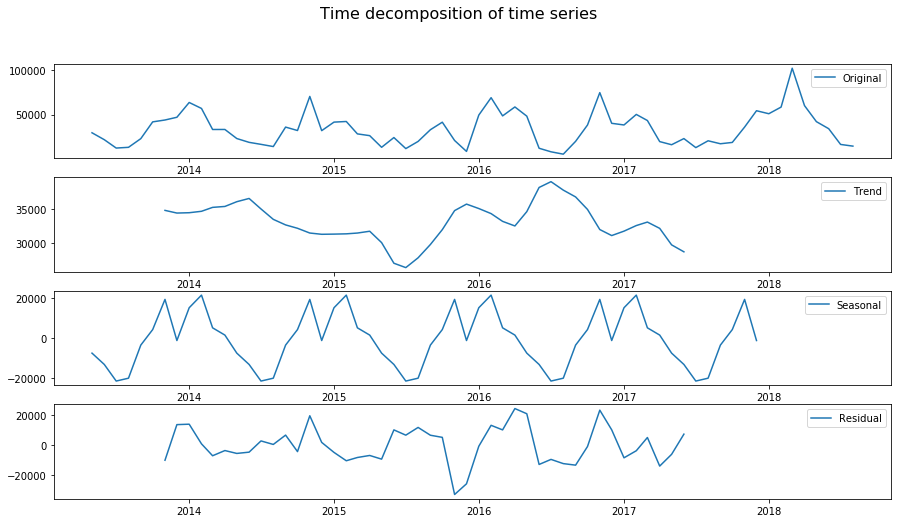

In [51]:
mpl.rc("figure", figsize=(15,8))
fig = plt.figure()
ax1 = fig.add_subplot(411, adjustable='box-forced')
ax2 = fig.add_subplot(412, adjustable='box-forced', sharex=ax1)
ax3 = fig.add_subplot(413, adjustable='box-forced', sharex=ax1)
ax4 = fig.add_subplot(414, adjustable='box-forced', sharex=ax1)

fig.suptitle('Time decomposition of time series', fontsize=16)

ax1.plot(data['rain_all'], label='Original')
ax1.legend(loc='best')
ax2.plot(trend, label='Trend')
ax2.legend(loc='best')
ax3.plot(seasonal, label='Seasonal')
ax3.legend(loc='best')
ax4.plot(residual, label='Residual')
ax4.legend(loc='best')

**Testing stationarity**

In [54]:
# https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    mpl.rc("figure", figsize=(15,6))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

/Users/eabrilm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  """
/Users/eabrilm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  


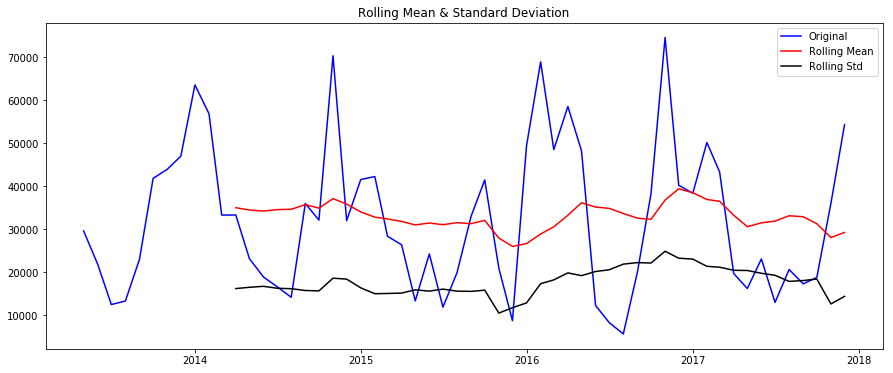

In [55]:
test_stationarity(ts)

Text(0.5,1,'Autocorrelation Function')

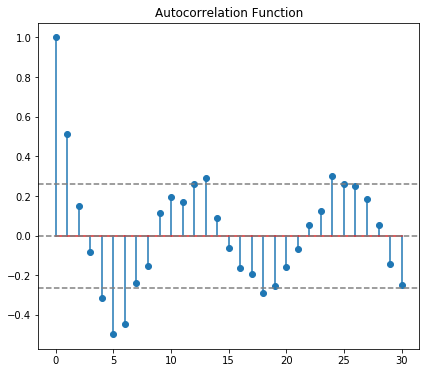

In [56]:
#Autocorrelation
lag_acf = acf(ts, nlags=30)

#Plot ACF: 
mpl.rc("figure", figsize=(15,6))
plt.subplot(121) 
plt.stem(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

**Doing the serie stationary**

Text(0.5,1,'Autocorrelation Function')

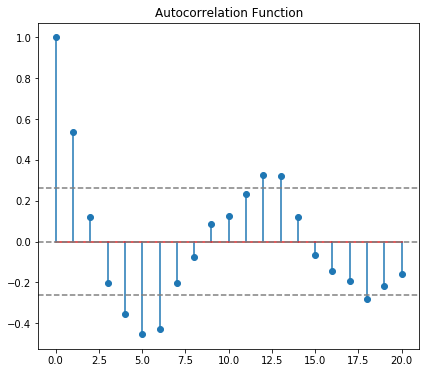

In [57]:
# 1.- Transformation
ts_log = np.log(ts)

#Autocorrelation
lag_acf = acf(ts_log, nlags=20)

#Plot ACF: 
mpl.rc("figure", figsize=(15,6))
plt.subplot(121) 
plt.stem(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

/Users/eabrilm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  """
/Users/eabrilm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  


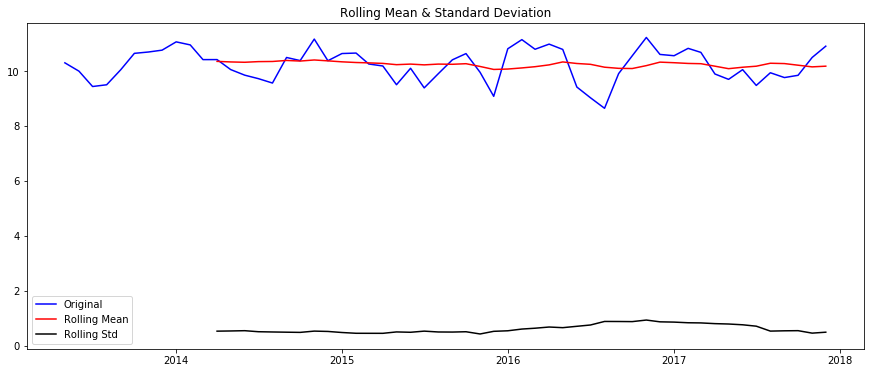

In [58]:
test_stationarity(ts_log)

Text(0.5,1,'Autocorrelation Function')

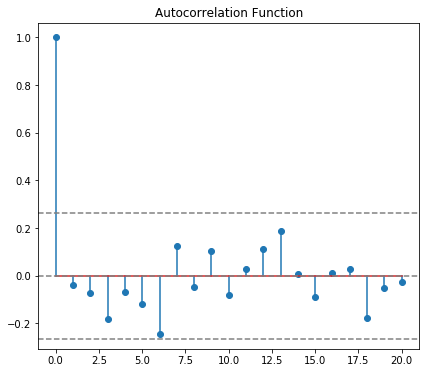

In [59]:
# 2.- De-trending
ts_log_diff = ts_log - ts_log.shift()
ts_log_diff.dropna(inplace=True)

#Autocorrelation
lag_acf = acf(ts_log_diff, nlags=20)

#Plot ACF: 
mpl.rc("figure", figsize=(15,6))
plt.subplot(121) 
plt.stem(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

/Users/eabrilm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  """
/Users/eabrilm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  


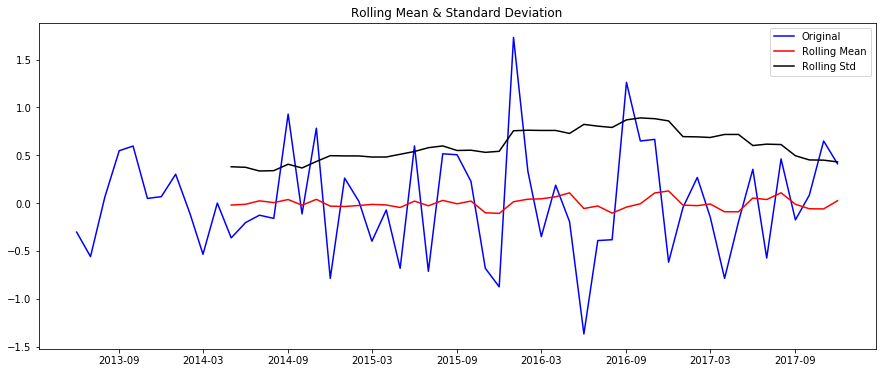

In [60]:
test_stationarity(ts_log_diff)

/Users/eabrilm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  


Text(0.5,1,'Autocorrelation Function')

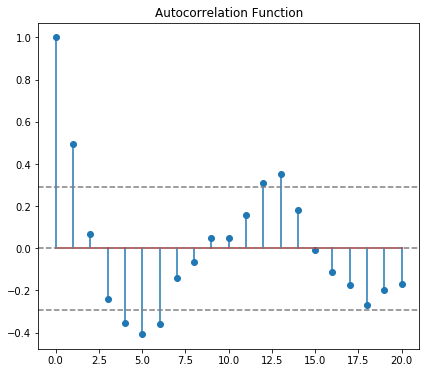

In [61]:
# 3.- Seasonal adjustment
moving_avg = pd.rolling_mean(ts_log,12)
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.dropna(inplace=True)

#Autocorrelation
lag_acf = acf(ts_log_moving_avg_diff, nlags=20)

#Plot ACF: 
mpl.rc("figure", figsize=(15,6))
plt.subplot(121) 
plt.stem(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_moving_avg_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_moving_avg_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

/Users/eabrilm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  """
/Users/eabrilm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  


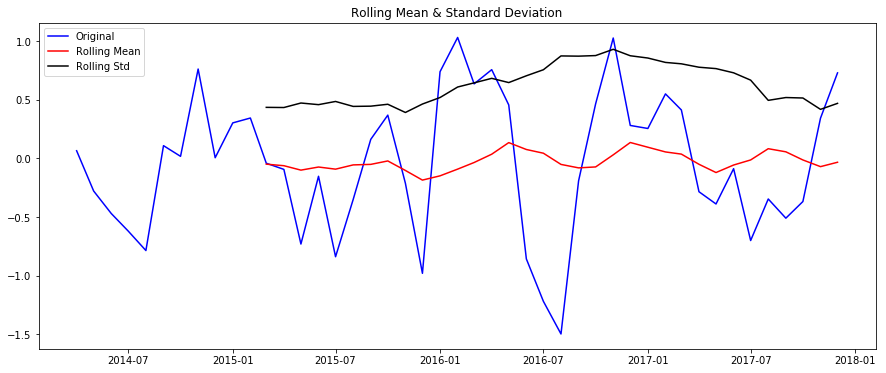

In [62]:
test_stationarity(ts_log_moving_avg_diff)

/Users/eabrilm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(halflife=12,min_periods=0,adjust=True,ignore_na=False).mean()
  


Text(0.5,1,'Autocorrelation Function')

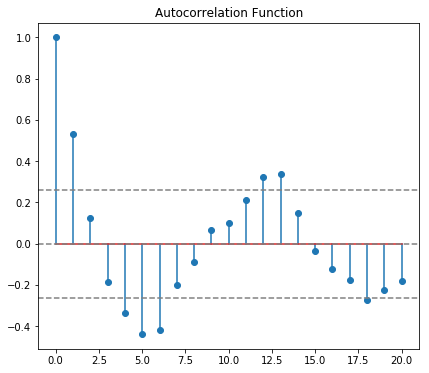

In [100]:
# 4.- EDA smoothing
expwighted_avg = pd.ewma(ts_log, halflife=12)
ts_log_ewma_diff = ts_log - expwighted_avg
ts_log_ewma_diff.dropna(inplace=True)

#Autocorrelation
lag_acf = acf(ts_log_ewma_diff, nlags=20)

#Plot ACF: 
mpl.rc("figure", figsize=(15,6))
plt.subplot(121) 
plt.stem(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_ewma_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_ewma_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

/Users/eabrilm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  """
/Users/eabrilm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  


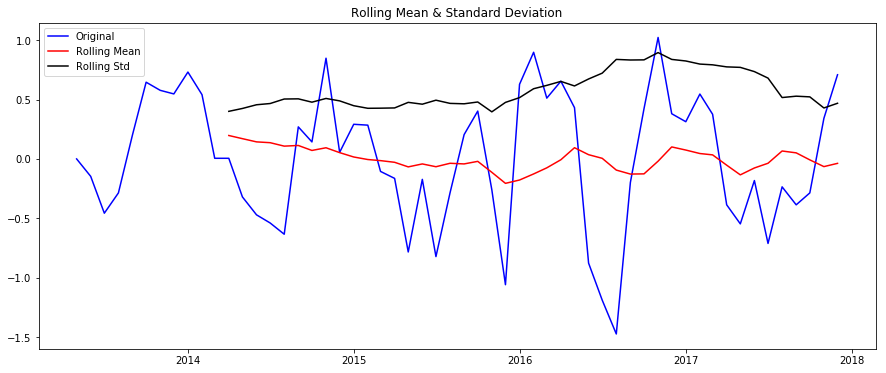

In [101]:
test_stationarity(ts_log_ewma_diff)

**Preparing a model**

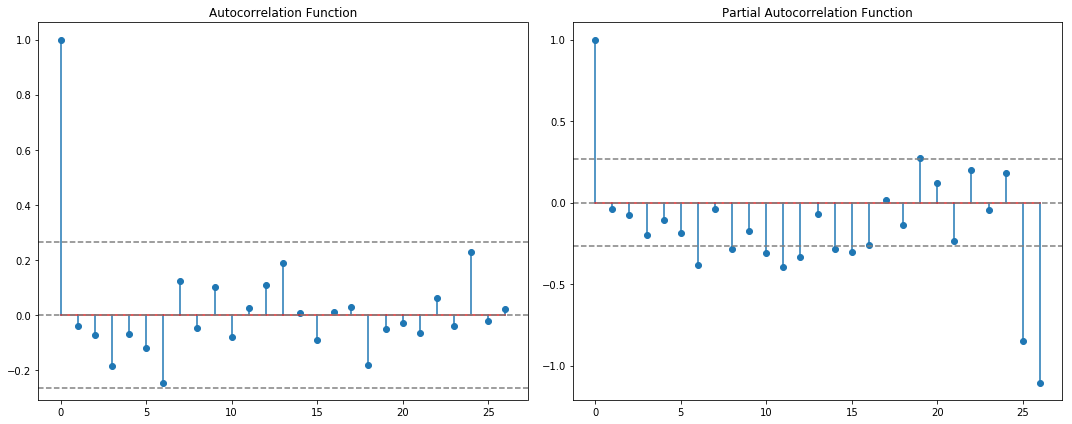

In [63]:
lag_acf = acf(ts_log_diff, nlags=26)
lag_pacf = pacf(ts_log_diff, nlags=26, method='ols')

#Plot ACF: 
mpl.rc("figure", figsize=(15,6))
plt.subplot(121) 
plt.stem(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.stem(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

**Model AR**

In [64]:
fit_ar = ARIMA(order=(6, 1, 0)).fit(y=ts)
fit_ar

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(6, 1, 0),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=None, solver='lbfgs', start_params=None,
   suppress_warnings=False, transparams=True, trend='c')

In [65]:
forecast_ar = fit_ar.predict(n_periods=8)

In [66]:
rmse_error_ar = np.sqrt(mean_squared_error(data.loc['2018-01-01':'2018-08-01','rain_all'], forecast_ar))
print("Test RMSE: %.3f" % rmse_error_ar)

Test RMSE: 26904.984


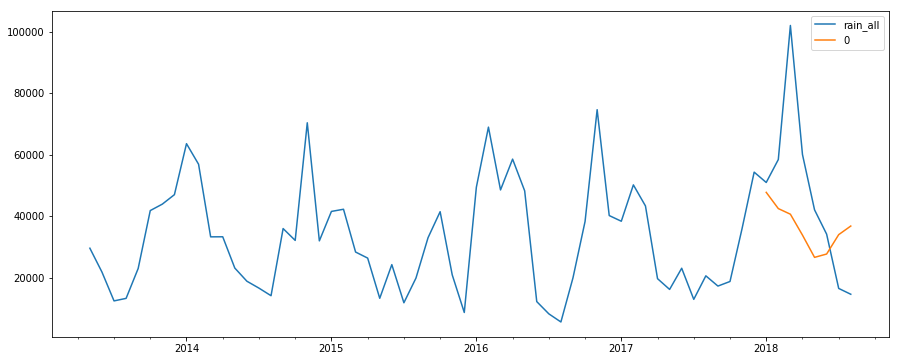

In [67]:
pd.concat([pd.Series(data['rain_all']), 
           pd.Series(forecast_ar, index=[pd.Timestamp('2018-01-01'), 
                                             pd.Timestamp('2018-02-01'), 
                                             pd.Timestamp('2018-03-01'), 
                                             pd.Timestamp('2018-04-01'), 
                                             pd.Timestamp('2018-05-01'), 
                                             pd.Timestamp('2018-06-01'), 
                                             pd.Timestamp('2018-07-01'), 
                                             pd.Timestamp('2018-08-01')])],axis=1).plot()

**Model MA**

In [68]:
fit_ma = ARIMA(order=(0, 1, 5)).fit(y=ts)
fit_ma

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(0, 1, 5),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=None, solver='lbfgs', start_params=None,
   suppress_warnings=False, transparams=True, trend='c')

In [69]:
forecast_ma = fit_ma.predict(n_periods=8)

In [70]:
rmse_error_ma = np.sqrt(mean_squared_error(data.loc['2018-01-01':'2018-08-01','rain_all'], forecast_ma))
print("Test RMSE: %.3f" % rmse_error_ma)

Test RMSE: 24509.626


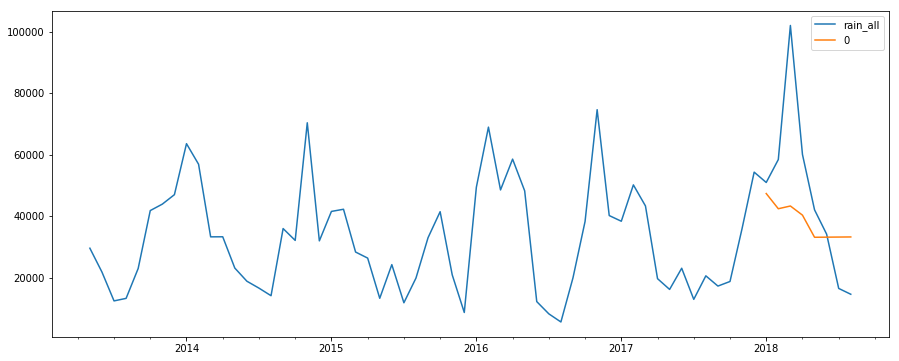

In [71]:
pd.concat([pd.Series(data['rain_all']), 
           pd.Series(forecast_ma, index=[pd.Timestamp('2018-01-01'), 
                                             pd.Timestamp('2018-02-01'), 
                                             pd.Timestamp('2018-03-01'), 
                                             pd.Timestamp('2018-04-01'), 
                                             pd.Timestamp('2018-05-01'), 
                                             pd.Timestamp('2018-06-01'), 
                                             pd.Timestamp('2018-07-01'), 
                                             pd.Timestamp('2018-08-01')])],axis=1).plot()

**Model ARIMA**

In [72]:
fit_arima = ARIMA(order=(5, 1, 1)).fit(y=ts)
fit_arima

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(5, 1, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=None, solver='lbfgs', start_params=None,
   suppress_warnings=False, transparams=True, trend='c')

In [73]:
forecast_arima = fit_arima.predict(n_periods=8)

In [74]:
rmse_error_arima = np.sqrt(mean_squared_error(data.loc['2018-01-01':'2018-08-01','rain_all'], forecast_arima))
print("Test RMSE: %.3f" % rmse_error_arima)

Test RMSE: 27878.986


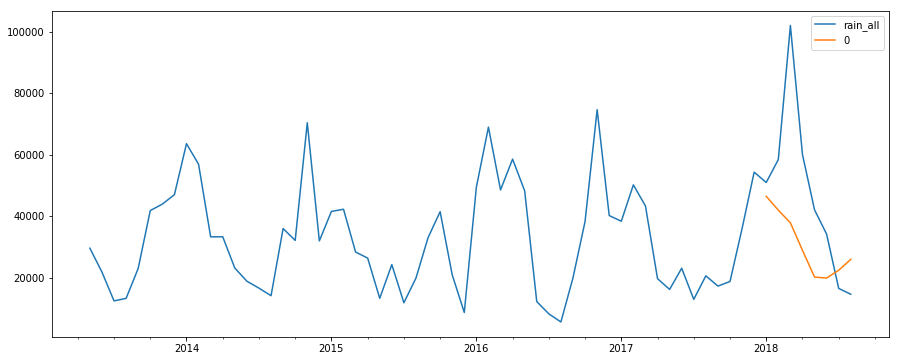

In [75]:
pd.concat([pd.Series(data['rain_all']), 
           pd.Series(forecast_arima, index=[pd.Timestamp('2018-01-01'), 
                                             pd.Timestamp('2018-02-01'), 
                                             pd.Timestamp('2018-03-01'), 
                                             pd.Timestamp('2018-04-01'), 
                                             pd.Timestamp('2018-05-01'), 
                                             pd.Timestamp('2018-06-01'), 
                                             pd.Timestamp('2018-07-01'), 
                                             pd.Timestamp('2018-08-01')])],axis=1).plot()

**Seasonal ARIMA**

In [76]:
fit_sarima = ARIMA(order=(5, 1, 1), seasonal_order=(2, 1, 0, 12)).fit(y=ts)
fit_sarima

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(5, 1, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(2, 1, 0, 12), solver='lbfgs', start_params=None,
   suppress_warnings=False, transparams=True, trend='c')

In [77]:
forecast_sarima = fit_sarima.predict(n_periods=8)

In [78]:
rmse_error_sarima = np.sqrt(mean_squared_error(data.loc['2018-01-01':'2018-08-01','rain_all'], forecast_sarima))
print("Test RMSE: %.3f" % rmse_error_sarima)

Test RMSE: 21892.210


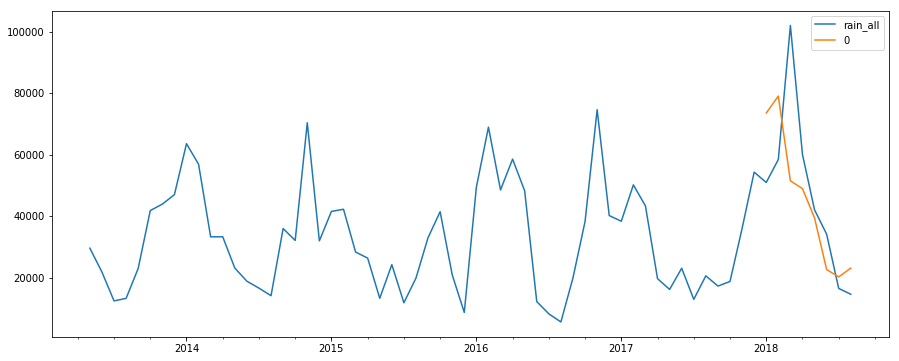

In [79]:
pd.concat([pd.Series(data['rain_all']), 
           pd.Series(forecast_sarima, index=[pd.Timestamp('2018-01-01'), 
                                             pd.Timestamp('2018-02-01'), 
                                             pd.Timestamp('2018-03-01'), 
                                             pd.Timestamp('2018-04-01'), 
                                             pd.Timestamp('2018-05-01'), 
                                             pd.Timestamp('2018-06-01'), 
                                             pd.Timestamp('2018-07-01'), 
                                             pd.Timestamp('2018-08-01')])],axis=1).plot()

**Preparing plot**

In [80]:
plot_ar = pd.concat([pd.Series(data['rain_all']), pd.Series(forecast_ar, index=[pd.Timestamp('2018-01-01'),
                                                                                pd.Timestamp('2018-02-01'),
                                                                                pd.Timestamp('2018-03-01'), 
                                                                                pd.Timestamp('2018-04-01'),
                                                                                pd.Timestamp('2018-05-01'),
                                                                                pd.Timestamp('2018-06-01'), 
                                                                                pd.Timestamp('2018-07-01'), 
                                                                                pd.Timestamp('2018-08-01')])],axis=1)

plot_ma = pd.concat([pd.Series(data['rain_all']), pd.Series(forecast_ma, index=[pd.Timestamp('2018-01-01'),
                                                                                pd.Timestamp('2018-02-01'),
                                                                                pd.Timestamp('2018-03-01'), 
                                                                                pd.Timestamp('2018-04-01'),
                                                                                pd.Timestamp('2018-05-01'),
                                                                                pd.Timestamp('2018-06-01'), 
                                                                                pd.Timestamp('2018-07-01'), 
                                                                                pd.Timestamp('2018-08-01')])],axis=1)

plot_arima = pd.concat([pd.Series(data['rain_all']), pd.Series(forecast_arima, index=[pd.Timestamp('2018-01-01'),
                                                                                pd.Timestamp('2018-02-01'),
                                                                                pd.Timestamp('2018-03-01'), 
                                                                                pd.Timestamp('2018-04-01'),
                                                                                pd.Timestamp('2018-05-01'),
                                                                                pd.Timestamp('2018-06-01'), 
                                                                                pd.Timestamp('2018-07-01'), 
                                                                                pd.Timestamp('2018-08-01')])],axis=1)

plot_sarima = pd.concat([pd.Series(data['rain_all']),
                         pd.Series(forecast_sarima, index=[pd.Timestamp('2018-01-01'),
                                                           pd.Timestamp('2018-02-01'),
                                                           pd.Timestamp('2018-03-01'), 
                                                           pd.Timestamp('2018-04-01'), 
                                                           pd.Timestamp('2018-05-01'),
                                                           pd.Timestamp('2018-06-01'), 
                                                           pd.Timestamp('2018-07-01'), 
                                                           pd.Timestamp('2018-08-01')])],axis=1)

Text(0.5,1,'SARIMAX (5,1,1) (2,1,0,12) | RMSE: 21892.210')

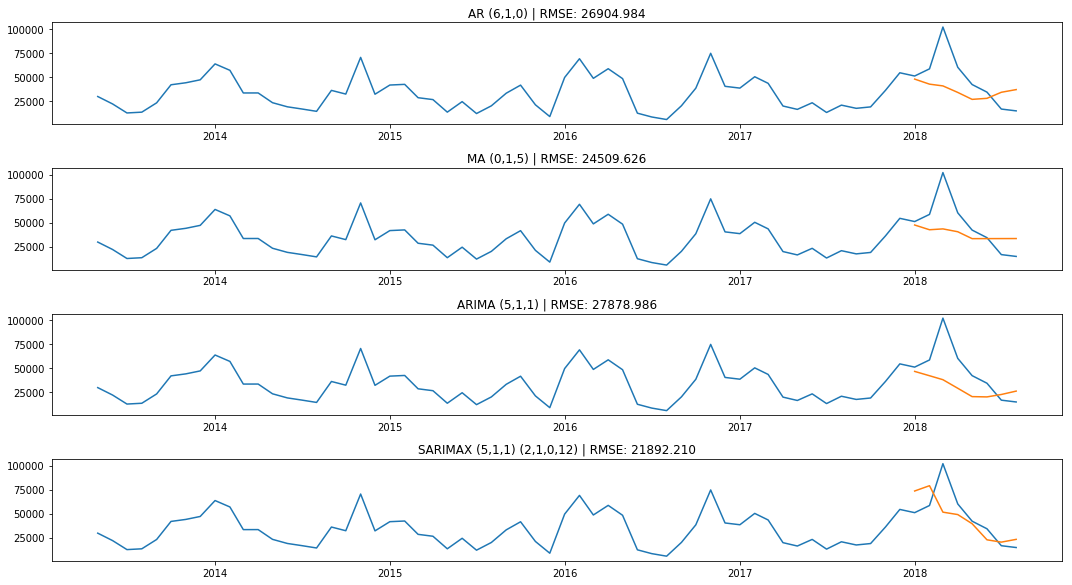

In [81]:
mpl.rc("figure", figsize=(15,8))

plt.subplot(411)
plt.plot(plot_ar, label='AR')
plt.title(f'AR (6,1,0) | RMSE: {rmse_error_ar:.3f}')
plt.subplot(412)
plt.plot(plot_ma, label='MA')
plt.title(f'MA (0,1,5) | RMSE: {rmse_error_ma:.3f}')
plt.subplot(413)
plt.plot(plot_arima, label='ARIMA')
plt.title(f'ARIMA (5,1,1) | RMSE: {rmse_error_arima:.3f}')
plt.tight_layout()
plt.subplot(414)
plt.plot(plot_sarima, label='SARIMA')
plt.title(f'SARIMAX (5,1,1) (2,1,0,12) | RMSE: {rmse_error_sarima:.3f}')